<a href="https://colab.research.google.com/github/Youssefhassan1717/Movie-System-Recommendation/blob/main/Movie%20System%20Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movies Recommender System
<h3>Made By<h3>
Youssef Abdelmaksoud<br>
Yassin Elasfar<br>
Islam Atwan<br>
Michael Wagdy



In this notebook, We will attempt at implementing a few recommendation algorithms (content based, popularity based and collaborative filtering) and try to build an ensemble of these models to come up with our final recommendation system. With us, we have two MovieLens datasets.

* **The Full Dataset:** Consists of 26,000,000 ratings and 750,000 tag applications applied to 45,000 movies by 270,000 users. Includes tag genome data with 12 million relevance scores across 1,100 tags.
* **The Small Dataset:** Comprises of 100,000 ratings and 1,300 tag applications applied to 9,000 movies by 700 users.

We will build a Simple Recommender using movies from the *Full Dataset* whereas all personalised recommender systems will make use of the small dataset . As a first step, We will build my simple recommender system.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.model_selection import train_test_split
import warnings; warnings.simplefilter('ignore')

## Simple Recommender

The Simple Recommender offers generalized recommnendations to every user based on movie popularity and (sometimes) genre. The basic idea behind this recommender is that movies that are more popular and more critically acclaimed will have a higher probability of being liked by the average audience. This model does not give personalized recommendations based on the user. 

The implementation of this model is extremely trivial. All we have to do is sort our movies based on ratings and popularity and display the top movies of our list. As an added step, we can pass in a genre argument to get the top movies of a particular genre. 

In [ ]:
md = pd.read_csv('/content/drive/MyDrive/Data/movies_metadata.csv')
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
md.isnull().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

In [ ]:
md.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

<h1>Checking & Handling for  Outliers for "runtime" column<h1>

<Axes: >

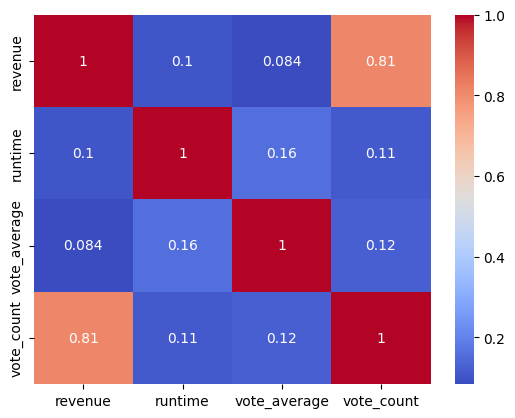

In [ ]:
# Select the numerical columns
num_cols = ['revenue', 'runtime', 'vote_average', 'vote_count']
# Compute the correlations
corr_matrix = md[num_cols].corr()

# Create a heatmap of the correlations
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

Dropping irrelevant columns: We will drop the "adult", "homepage", "imdb_id", "poster_path", "video" columns as they are not relevant for recommendation tasks, while belongs_to_collection column contain 40972 Nan values out of 45466. So we should drop it also.

In [ ]:
md.drop(["adult", "homepage", "imdb_id", "poster_path", "video", "belongs_to_collection"], axis=1, inplace=True)

Drop rows with missing values: You can drop rows with missing values in the "revenue", "runtime", "status", and "vote_average" columns since these are not important for recommendation tasks. You can also drop rows with missing values in the "genres" column since it's impossible to make recommendations without this information.

In [ ]:
md = md.dropna(subset=['revenue','runtime', 'status', 'vote_average', 'genres'])

Handle missing values in other columns: For columns with a small number of missing values, we can fill in the missing values with the mode or median. For example, we can fill in missing values in the "original_language" column with the mode.

In [ ]:
md['original_language'].fillna(md['original_language'].mode()[0], inplace=True)
md['release_date'].fillna(md['release_date'].mode()[0], inplace=True)
md['tagline'].fillna(md['tagline'].mode()[0], inplace=True)
md['overview'].fillna(md['overview'].mode()[0], inplace=True)

In [ ]:
md.isnull().sum()

budget                  0
genres                  0
id                      0
original_language       0
original_title          0
overview                0
popularity              0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
tagline                 0
title                   0
vote_average            0
vote_count              0
dtype: int64

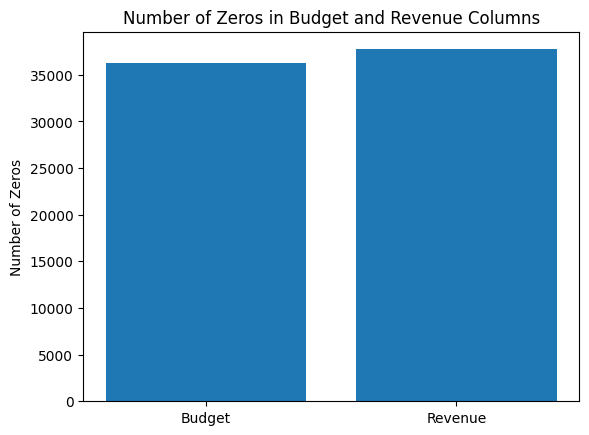

In [ ]:
# Count the number of zeros in the budget and revenue columns
num_zeros_in_budget = (md['budget'] == '0').sum()
num_zeros_in_revenue = (md['revenue'] == 0).sum()

# Create a bar chart of the number of zeros in the budget and revenue columns
fig, ax = plt.subplots()
ax.bar(['Budget', 'Revenue'], [num_zeros_in_budget, num_zeros_in_revenue])
ax.set_ylabel('Number of Zeros')
ax.set_title('Number of Zeros in Budget and Revenue Columns')
plt.show()

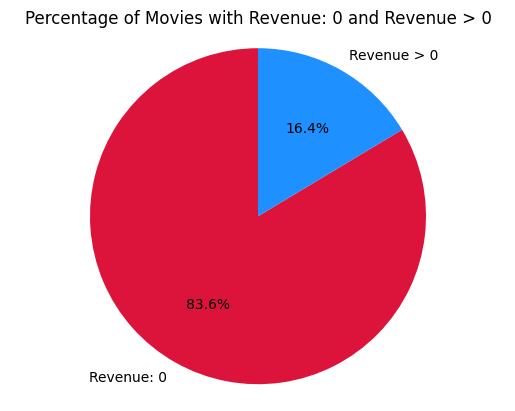

In [ ]:
# Count the number of movies with 0 revenue
num_zeros_in_revenue = (md['revenue'] == 0).sum()

# Count the number of movies with non-zero revenue
num_non_zeros_in_revenue = (md['revenue'].astype(int) != 0).sum()

# Calculate the percentage of movies with 0 revenue and non-zero revenue
percent_zeros = num_zeros_in_revenue / len(md) * 100
percent_non_zeros = num_non_zeros_in_revenue / len(md) * 100

# Create a list of labels and values for the pie chart
labels = ['Revenue: 0', 'Revenue > 0']
values = [percent_zeros, percent_non_zeros]

# Create the pie chart with custom colors
colors = ['crimson', 'dodgerblue']
fig, ax = plt.subplots()
ax.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax.axis('equal') # Set the aspect ratio to be equal to avoid a distorted chart
plt.title('Percentage of Movies with Revenue: 0 and Revenue > 0')
plt.show()

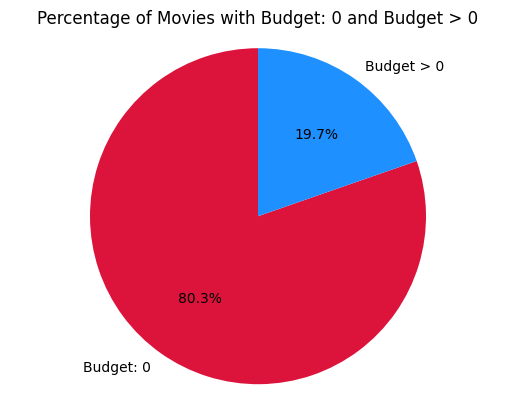

In [ ]:
# Count the number of movies with 0 budget
num_zeros_in_budget = (md['budget'] == '0').sum()

# Count the number of movies with non-zero budget
num_non_zeros_in_budget = (md['budget'].astype(int) != 0).sum()

# Calculate the percentage of movies with 0 budget and non-zero budget
percent_zeros = num_zeros_in_budget / len(md) * 100
percent_non_zeros = num_non_zeros_in_budget / len(md) * 100

# Create a list of labels and values for the pie chart
labels = ['Budget: 0', 'Budget > 0']
values = [percent_zeros, percent_non_zeros]

# Create the pie chart with custom colors
colors = ['crimson', 'dodgerblue']
fig, ax = plt.subplots()
ax.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax.axis('equal') # Set the aspect ratio to be equal to avoid a distorted chart
plt.title('Percentage of Movies with Budget: 0 and Budget > 0')
plt.show()

To improve the efficiency of our data analysis, we have decided to drop the revenue and budget columns from our dataset. After examining the data, we have found that a majority of the entries in these columns contain 0's, which would not add any value to our analysis. Therefore, we have decided to exclude these columns from our analysis going forward.

In [ ]:
md.drop(['revenue', 'budget'], axis=1, inplace=True)

<Axes: >

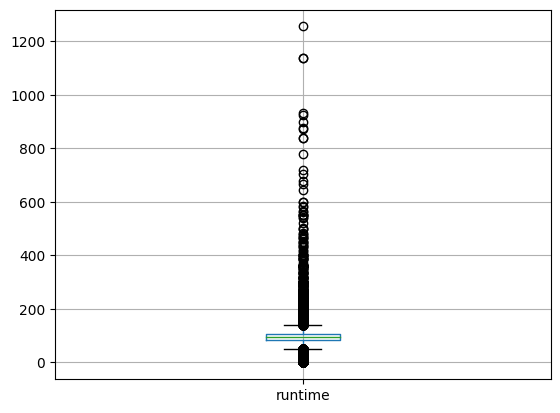

In [ ]:
md.boxplot(column=['runtime'])

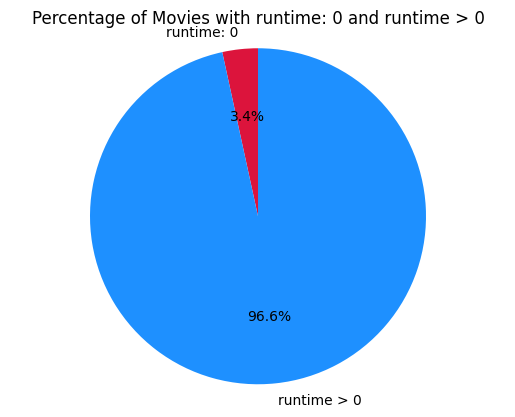

In [ ]:
# Count the number of movies with 0 budget
num_zeros_in_budget = (md['runtime'] == 0).sum()

# Count the number of movies with non-zero budget
num_non_zeros_in_budget = (md['runtime'].astype(int) != 0).sum()

# Calculate the percentage of movies with 0 budget and non-zero budget
percent_zeros = num_zeros_in_budget / len(md) * 100
percent_non_zeros = num_non_zeros_in_budget / len(md) * 100

# Create a list of labels and values for the pie chart
labels = ['runtime: 0', 'runtime > 0']
values = [percent_zeros, percent_non_zeros]

# Create the pie chart with custom colors
colors = ['crimson', 'dodgerblue']
fig, ax = plt.subplots()
ax.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax.axis('equal') # Set the aspect ratio to be equal to avoid a distorted chart
plt.title('Percentage of Movies with runtime: 0 and runtime > 0')
plt.show()

In [ ]:
# Calculate the median of non-zero values
median = md.loc[md['runtime'] != 0, 'runtime'].median()

# Replace the 0 values with the median
md['runtime'] = md['runtime'].replace(0, median)


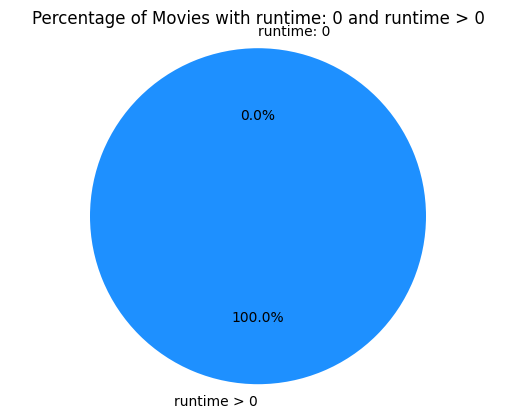

In [ ]:
# Count the number of movies with 0 budget
num_zeros_in_budget = (md['runtime'] == 0).sum()

# Count the number of movies with non-zero budget
num_non_zeros_in_budget = (md['runtime'].astype(int) != 0).sum()

# Calculate the percentage of movies with 0 budget and non-zero budget
percent_zeros = num_zeros_in_budget / len(md) * 100
percent_non_zeros = num_non_zeros_in_budget / len(md) * 100

# Create a list of labels and values for the pie chart
labels = ['runtime: 0', 'runtime > 0']
values = [percent_zeros, percent_non_zeros]

# Create the pie chart with custom colors
colors = ['crimson', 'dodgerblue']
fig, ax = plt.subplots()
ax.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax.axis('equal') # Set the aspect ratio to be equal to avoid a distorted chart
plt.title('Percentage of Movies with runtime: 0 and runtime > 0')
plt.show()

In [ ]:
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [ ]:
md.head()

,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,"[Animation, Comedy, Family]",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,Toy Story,7.7,5415.0
1,"[Adventure, Fantasy, Family]",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0
2,"[Romance, Comedy]",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0
3,"[Comedy, Drama, Romance]",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0
4,[Comedy],11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0


Data Cleaning Complete on movies_metadata dataset
----------------------------------------------------------------------------
We have successfully cleaned the md dataset by filling in the missing values appropriately and dropping the unnecessary columns. With the data cleaned, we can now proceed with our analysis or modeling and use the cleaned data to gain insights, build models, or answer research questions.

To fill in the missing values, we used the mode for object data types and the median or mean for float or integer data types. We also dropped columns that were not relevant to our analysis or modeling.
___________________________________________________________________________________________________
We use the TMDB Ratings to come up with our **Top Movies Chart.** We will use IMDB's *weighted rating* formula to construct my chart. Mathematically, it is represented as follows:

Weighted Rating (WR) = $(\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$

where,
* *v* is the number of votes for the movie
* *m* is the minimum votes required to be listed in the chart
* *R* is the average rating of the movie
* *C* is the mean vote across the whole report

The next step is to determine an appropriate value for *m*, the minimum votes required to be listed in the chart. We will use **95th percentile** as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 95% of the movies in the list.

We will build our overall Top 250 Chart and will define a function to build charts for a particular genre. Let's begin!

In [ ]:
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.257124495856048

In [ ]:
m = vote_counts.quantile(0.95)
m

437.0

In [ ]:
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [ ]:
md.head()

,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,year
0,"[Animation, Comedy, Family]",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,Toy Story,7.7,5415.0,1995
1,"[Adventure, Fantasy, Family]",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,1995
2,"[Romance, Comedy]",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,1995
3,"[Comedy, Drama, Romance]",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0,1995
4,[Comedy],11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0,1995


In [ ]:
qualified = md[(md['vote_count'] >= m) & (md['vote_count'].notnull()) & (md['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2258, 6)

Therefore, to qualify to be considered for the chart, a movie has to have at least **437 votes** on TMDB. We also see that the average rating for a movie on TMDB is **5.257** on a scale of 10.  **2258** Movies qualify to be on our chart.

In [ ]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [ ]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

### Top Movies

In [ ]:
qualified.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.917404
12481,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.905664
22879,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.896883
2843,Fight Club,1999,9678,8,63.869599,[Drama],7.881499
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.871515
292,Pulp Fiction,1994,8670,8,140.950236,"[Thriller, Crime]",7.868383
314,The Shawshank Redemption,1994,8358,8,51.645403,"[Drama, Crime]",7.863714
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,"[Adventure, Fantasy, Action]",7.861637
351,Forrest Gump,1994,8147,8,48.307194,"[Comedy, Drama, Romance]",7.860364
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,"[Adventure, Fantasy, Action]",7.851617


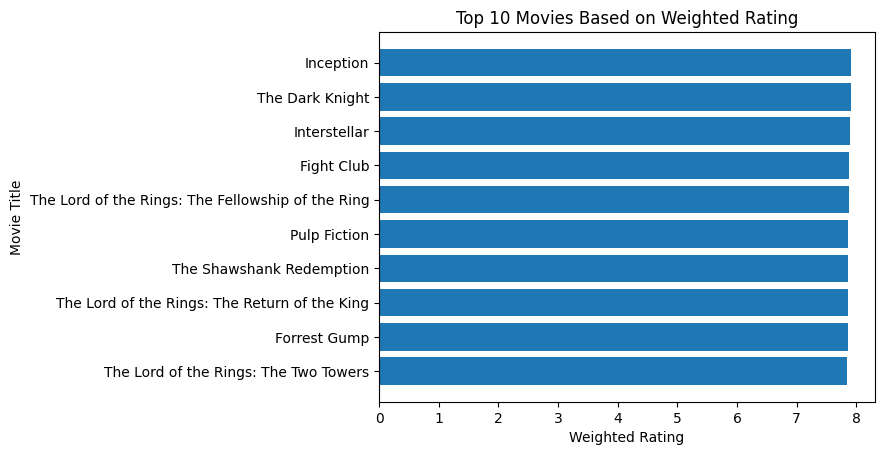

In [ ]:
top_movies = qualified.sort_values('wr', ascending=False).head(10)
top_movies = top_movies.sort_values('wr', ascending=True) # sort by wr in descending order
plt.barh(np.arange(len(top_movies)), top_movies['wr'])
plt.yticks(np.arange(len(top_movies)), top_movies['title'])
plt.xlabel('Weighted Rating')
plt.ylabel('Movie Title')
plt.title('Top 10 Movies Based on Weighted Rating')
plt.show()

In [ ]:
s = md.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = md.drop('genres', axis=1).join(s)
gen_md.head()

,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,year,genre
0,862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,Toy Story,7.7,5415.0,1995,Animation
0,862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,Toy Story,7.7,5415.0,1995,Comedy
0,862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,Toy Story,7.7,5415.0,1995,Family
1,8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,1995,Adventure
1,8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,1995,Fantasy


In [ ]:
def build_chart(genre, percentile=0.85):
    # Filter the gen_md DataFrame by the specified genre
    df = gen_md.loc[gen_md['genre'] == genre]
    
    # Compute the mean rating and vote count threshold
    C = df['vote_average'].mean()
    m = df['vote_count'].quantile(percentile)
    
    # Filter the qualified movies based on the vote count threshold
    qualified = df.loc[df['vote_count'] >= m]
    
    # Compute the weighted ratings for the qualified movies
    qualified['wr'] = (qualified['vote_count'] / (qualified['vote_count'] + m) * qualified['vote_average']) + (m / (qualified['vote_count'] + m) * C)
    
    # Sort the qualified movies by weighted rating and popularity
    qualified = qualified.sort_values(by=['wr', 'popularity'], ascending=False)
    
    # Return the top 10 movies
    return qualified[['title', 'year', 'vote_count', 'vote_average', 'popularity', 'wr']].head(10)

Let us see our method in action by displaying the Top 15 Romance Movies (Romance almost didn't feature at all in our Generic Top Chart despite  being one of the most popular movie genres).

### Top Romance Movies

In [ ]:
build_chart('Romance')


,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995,661.0,9.1,34.457024,8.701833
40251,Your Name.,2016,1030.0,8.5,34.461252,8.281604
351,Forrest Gump,1994,8147.0,8.2,48.307194,8.173595
1132,Cinema Paradiso,1988,834.0,8.2,14.177005,7.964841
40882,La La Land,2016,4745.0,7.9,19.681686,7.860665
22168,Her,2013,4215.0,7.9,13.829515,7.855824
7208,Eternal Sunshine of the Spotless Mind,2004,3758.0,7.9,12.906327,7.850579
876,Vertigo,1958,1162.0,8.0,18.20822,7.840924
3189,City Lights,1931,444.0,8.2,10.891524,7.793417
15530,Mr. Nobody,2009,1616.0,7.9,11.817059,7.788564


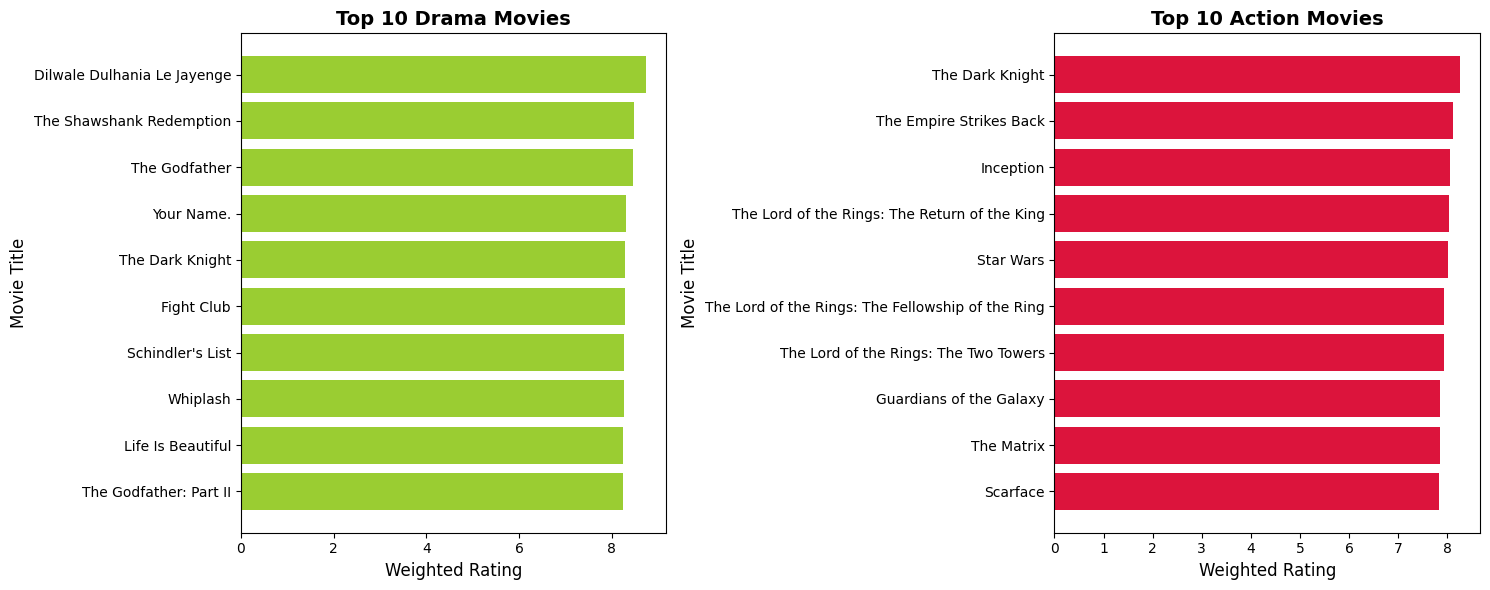

In [ ]:
# Call the build_chart function to get the top 10 Comedy movies
top_comedy = build_chart('Drama').head(10)

# Call the build_chart function to get the top 10 Action movies
top_action = build_chart('Action').head(10)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Create a horizontal bar chart of the top 10 Comedy movies
ax1.barh(top_comedy['title'], top_comedy['wr'], color='yellowgreen')
ax1.set_xlabel('Weighted Rating', fontsize=12)
ax1.set_ylabel('Movie Title', fontsize=12)
ax1.set_title('Top 10 Drama Movies', fontsize=14, fontweight='bold')
ax1.invert_yaxis() # Invert the y-axis to display the highest-rated movie at the top
ax1.tick_params(axis='y', labelsize=10)

# Create a horizontal bar chart of the top 10 Action movies
ax2.barh(top_action['title'], top_action['wr'], color='crimson')
ax2.set_xlabel('Weighted Rating', fontsize=12)
ax2.set_ylabel('Movie Title', fontsize=12)
ax2.set_title('Top 10 Action Movies', fontsize=14, fontweight='bold')
ax2.invert_yaxis() # Invert the y-axis to display the highest-rated movie at the top
ax2.tick_params(axis='y', labelsize=10)

# Adjust the layout to prevent overlapping labels
plt.tight_layout()

# Display the bar charts for top 10 Comedy and Action movies in the same line
plt.show()

## Content Based Recommender

The recommender we built in the previous section suffers some severe limitations. For one, it gives the same recommendation to everyone, regardless of the user's personal taste. If a person who loves romantic movies (and hates action) were to look at our Top 15 Chart, s/he wouldn't probably like most of the movies. If s/he were to go one step further and look at our charts by genre, s/he wouldn't still be getting the best recommendations.

For instance, consider a person who loves *Dilwale Dulhania Le Jayenge*, *My Name is Khan* and *Kabhi Khushi Kabhi Gham*. One inference we can obtain is that the person loves the actor Shahrukh Khan and the director Karan Johar. Even if s/he were to access the romance chart, s/he wouldn't find these as the top recommendations.

To personalise our recommendations more, I am going to build an engine that computes similarity between movies based on certain metrics and suggests movies that are most similar to a particular movie that a user liked. Since we will be using movie metadata (or content) to build this engine, this also known as **Content Based Filtering.**

We will build two Content Based Recommenders based on:
* Movie Overviews  
* Movie Cast, Crew, Keywords and Genre

Also, as mentioned in the introduction, We will be using a subset of all the movies available to us due to limiting computing power available to me. 

In [ ]:
links_small = pd.read_csv('/content/drive/MyDrive/Data/links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')
links_small.head()

0      862
1     8844
2    15602
3    31357
4    11862
Name: tmdbId, dtype: int64

In [ ]:
links_small.isnull().sum()

0

In [ ]:
links_small.duplicated().sum()

0

In [ ]:
md['id'] = md['id'].astype('int')

In [ ]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9097, 17)

We have **9097** movies avaiable in our small movies metadata dataset which is 5 times smaller than our original dataset of 45000 movies.

### Movie Description Based Recommender

Let us first try to build a recommender using movie descriptions and taglines. We do not have a quantitative metric to judge our machine's performance so this will have to be done qualitatively.

In [ ]:
smd.isnull().sum()

genres                  0
id                      0
original_language       0
original_title          0
overview                0
popularity              0
production_companies    0
production_countries    0
release_date            0
runtime                 0
spoken_languages        0
status                  0
tagline                 0
title                   0
vote_average            0
vote_count              0
year                    0
dtype: int64

In [ ]:
smd

,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,year
0,"[Animation, Comedy, Family]",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,Toy Story,7.7,5415.0,1995
1,"[Adventure, Fantasy, Family]",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,1995
2,"[Romance, Comedy]",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,1995
3,"[Comedy, Drama, Romance]",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0,1995
4,[Comedy],11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40224,"[Action, Adventure, Drama, Horror, Science Fic...",315011,ja,シン・ゴジラ,From the mind behind Evangelion comes a hit la...,9.285519,"[{'name': 'Cine Bazar', 'id': 5896}, {'name': ...","[{'iso_3166_1': 'JP', 'name': 'Japan'}]",2016-07-29,120.0,"[{'iso_639_1': 'it', 'name': 'Italiano'}, {'is...",Released,A god incarnate. A city doomed.,Shin Godzilla,6.6,152.0,2016
40503,"[Documentary, Music]",391698,en,The Beatles: Eight Days a Week - The Touring Y...,"The band stormed Europe in 1963, and, in 1964,...",7.078301,"[{'name': 'Imagine Entertainment', 'id': 23}, ...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2016-09-15,99.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The band you know. The story you don't.,The Beatles: Eight Days a Week - The Touring Y...,7.6,92.0,2016
44821,"[Adventure, Fantasy, Animation, Action, Family]",10991,ja,Pokémon 3: The Movie,When Molly Hale's sadness of her father's disa...,6.480376,"[{'name': 'TV Tokyo', 'id': 3034}, {'name': '4...","[{'iso_3166_1': 'JP', 'name': 'Japan'}]",2000-07-08,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Pokémon: Spell of the Unknown,Pokémon: Spell of the Unknown,6.0,144.0,2000
44826,"[Adventure, Fantasy, Animation, Science Fictio...",12600,ja,劇場版ポケットモンスター セレビィ 時を越えた遭遇（であい）,"All your favorite Pokémon characters are back,...",6.080108,[],"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",2001-07-06,75.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,Based on a true story.,Pokémon 4Ever: Celebi - Voice of the Forest,5.7,82.0,2001


In [ ]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['overview'])

In [ ]:
tfidf_matrix.shape

(9097, 244136)

#### Cosine Similarity

We will be using the Cosine Similarity to calculate a numeric quantity that denotes the similarity between two movies. Mathematically, it is defined as follows:

$cosine(x,y) = \frac{x. y^\intercal}{||x||.||y||} $

Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's **linear_kernel** instead of cosine_similarities since it is much faster.

In [ ]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
cosine_sim[0]

array([1.        , 0.00743019, 0.        , ..., 0.        , 0.00345898,
       0.        ])

We now have a pairwise cosine similarity matrix for all the movies in our dataset. The next step is to write a function that returns the 30 most similar movies based on the cosine similarity score.

In [ ]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [ ]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # Select the top 10 similar movies
    movie_indices = [i[0] for i in sim_scores]
    movie_scores = [i[1] for i in sim_scores]
    return titles.iloc[movie_indices], movie_scores

We're all set. Let us now try and get the top recommendations for a few movies and see how good the recommendations are.

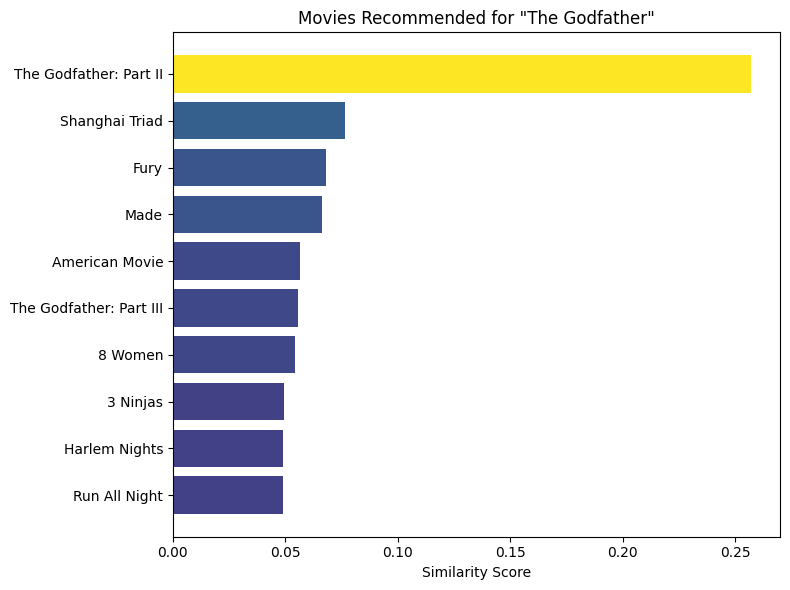

In [ ]:
rec_titles, rec_scores = get_recommendations('The Godfather')

# Plot the recommendations with similarity scores
fig, ax = plt.subplots(figsize=(8, 6))
bar_colors = plt.cm.viridis(np.array(rec_scores) / max(rec_scores))  # Scale the scores to the range [0, 1]

ax.barh(np.arange(len(rec_titles)), rec_scores, color=bar_colors)
ax.set_yticks(np.arange(len(rec_titles)))
ax.set_yticklabels(rec_titles, fontsize=10)
ax.invert_yaxis()
ax.set_xlabel('Similarity Score')
ax.set_title('Movies Recommended for "The Godfather"')

plt.tight_layout()
plt.show()

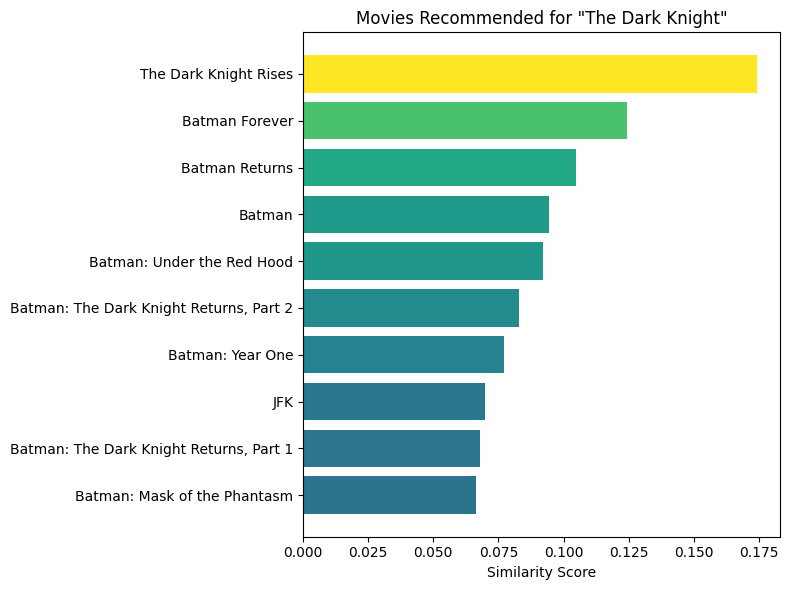

In [ ]:
rec_titles, rec_scores = get_recommendations('The Dark Knight')

# Plot the recommendations with similarity scores
fig, ax = plt.subplots(figsize=(8, 6))
bar_colors = plt.cm.viridis(np.array(rec_scores) / max(rec_scores))  # Scale the scores to the range [0, 1]

ax.barh(np.arange(len(rec_titles)), rec_scores, color=bar_colors)
ax.set_yticks(np.arange(len(rec_titles)))
ax.set_yticklabels(rec_titles, fontsize=10)
ax.invert_yaxis()
ax.set_xlabel('Similarity Score')
ax.set_title('Movies Recommended for "The Dark Knight"')

plt.tight_layout()
plt.show()

We see that for **The Dark Knight**, our system is able to identify it as a Batman film and subsequently recommend other Batman films as its top recommendations. But unfortunately, that is all this system can do at the moment. This is not of much use to most people as it doesn't take into considerations very important features such as cast, crew, director and genre, which determine the rating and the popularity of a movie. Someone who liked **The Dark Knight** probably likes it more because of Nolan and would hate **Batman Forever** and every other substandard movie in the Batman Franchise.

Therefore, we are going to use much more suggestive metadata than **Overview** and **Tagline**. In the next subsection, we will build a more sophisticated recommender that takes **genre**, **keywords**, **cast** and **crew** into consideration.

### Metadata Based Recommender

To build our standard metadata based content recommender, we will need to merge our current dataset with the crew and the keyword datasets. Let us prepare this data as our first step.

In [ ]:
credits = pd.read_csv('/content/drive/MyDrive/Data/credits.csv')
keywords =pd.read_csv('/content/drive/MyDrive/Data/keywords.csv')

<h2>Checking for Null Values<h2>

In [ ]:
credits.isnull().sum()

cast    0
crew    0
id      0
dtype: int64

In [ ]:
keywords.isnull().sum()

id          0
keywords    0
dtype: int64

<h2>Checking for Duplicates<h2>

In [ ]:
credits.duplicated().sum()

37

In [ ]:
credits=credits.drop_duplicates()

In [ ]:
credits.duplicated().sum()

0

In [ ]:
keywords.duplicated().sum()

987

In [ ]:
keywords=keywords.drop_duplicates()

In [ ]:
keywords.duplicated().sum()

0

In [ ]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
md['id'] = md['id'].astype('int')

In [ ]:
md.shape

(45126, 17)

In [ ]:
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')

In [ ]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9105, 20)

In [ ]:
smd

,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,year,cast,crew,keywords
0,"[Animation, Comedy, Family]",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,Toy Story,7.7,5415.0,1995,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,"[Adventure, Fantasy, Family]",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,1995,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,"[Romance, Comedy]",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,1995,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,"[Comedy, Drama, Romance]",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0,1995,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,[Comedy],11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0,1995,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39569,[Drama],159550,en,The Last Brickmaker in America,A man must cope with the loss of his wife and ...,0.038998,"[{'name': 'Nasser Entertainment', 'id': 35802}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2001-09-23,85.0,[],Released,Based on a true story.,The Last Brickmaker in America,7.0,1.0,2001,"[{'cast_id': 1, 'character': 'Henry Cobb', 'cr...","[{'credit_id': '544475aac3a36819fb000578', 'de...","[{'id': 6054, 'name': 'friendship'}, {'id': 20..."
39785,"[Thriller, Romance]",392572,hi,रुस्तम,"Rustom Pavri, an honourable officer of the Ind...",7.333139,"[{'name': 'KriArj Entertainment', 'id': 91689}]","[{'iso_3166_1': 'IN', 'name': 'India'}]",2016-08-12,150.0,"[{'iso_639_1': 'hi', 'name': 'हिन्दी'}]",Released,Decorated Officer. Devoted Family Man. Defendi...,Rustom,7.3,25.0,2016,"[{'cast_id': 0, 'character': 'Rustom Pavri', '...","[{'credit_id': '5951baf692514129c4016600', 'de...","[{'id': 10540, 'name': 'bollywood'}]"
39838,"[Adventure, Drama, History, Romance]",402672,hi,Mohenjo Daro,"Village lad Sarman is drawn to big, bad Mohenj...",1.423358,"[{'name': 'UTV Motion Pictures', 'id': 2320}, ...","[{'i

We now have our cast, crew, genres and credits, all in one dataframe. Let us wrangle this a little more using the following intuitions:

1. **Crew:** From the crew, we will only pick the director as our feature since the others don't contribute that much to the *feel* of the movie.
2. **Cast:** Choosing Cast is a little more tricky. Lesser known actors and minor roles do not really affect people's opinion of a movie. Therefore, we must only select the major characters and their respective actors. Arbitrarily we will choose the top 3 actors that appear in the credits list. 

In [ ]:
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [ ]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
smd['director'] = smd['crew'].apply(get_director)

In [ ]:
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [ ]:
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [ ]:
smd.head()

,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,...,title,vote_average,vote_count,year,cast,crew,keywords,cast_size,crew_size,director
0,"[Animation, Comedy, Family]",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,81.0,...,Toy Story,7.7,5415.0,1995,"[Tom Hanks, Tim Allen, Don Rickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy, friendship, friends, riva...",13,106,John Lasseter
1,"[Adventure, Fantasy, Family]",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,104.0,...,Jumanji,6.9,2413.0,1995,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[board game, disappearance, based on children'...",26,16,Joe Johnston
2,"[Romance, Comedy]",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,101.0,...,Grumpier Old Men,6.5,92.0,1995,"[Walter Matthau, Jack Lemmon, Ann-Margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fishing, best friend, duringcreditsstinger, o...",7,4,Howard Deutch
3,"[Comedy, Drama, Romance]",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,127.0,...,Waiting to Exhale,6.1,34.0,1995,"[Whitney Houston, Angela Bassett, Loretta Devine]","[{'credit_id': '52fe44779251416c91011acb', 'de...","[based on novel, interracial relationship, sin...",10,10,Forest Whitaker
4,[Comedy],11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,106.0,...,Father of the Bride Part II,5.7,173.0,1995,"[Steve Martin, Diane Keaton, Martin Short]","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[baby, midlife crisis, confidence, aging, daug...",12,7,Charles Shyer


Our approach to build the recommender is going to be extremely *hacky*. What we plan on doing is creating a metadata dump for every movie which consists of **genres, director, main actors and keywords.** We then use a **Count Vectorizer** to create our count matrix as we did in the Description Recommender. The remaining steps are similar to what we did earlier: we calculate the cosine similarities and return movies that are most similar.

These are steps We follow in the preparation of my genres and credits data:
1. **Strip Spaces and Convert to Lowercase** from all our features. This way, our engine will not confuse between **Johnny Depp** and **Johnny Galecki.** 
2. **Mention Director 3 times** to give it more weight relative to the entire cast.

In [ ]:
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [ ]:
smd.head()

,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,...,title,vote_average,vote_count,year,cast,crew,keywords,cast_size,crew_size,director
0,"[Animation, Comedy, Family]",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,81.0,...,Toy Story,7.7,5415.0,1995,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy, friendship, friends, riva...",13,106,John Lasseter
1,"[Adventure, Fantasy, Family]",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,104.0,...,Jumanji,6.9,2413.0,1995,"[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[board game, disappearance, based on children'...",26,16,Joe Johnston
2,"[Romance, Comedy]",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,101.0,...,Grumpier Old Men,6.5,92.0,1995,"[waltermatthau, jacklemmon, ann-margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fishing, best friend, duringcreditsstinger, o...",7,4,Howard Deutch
3,"[Comedy, Drama, Romance]",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,127.0,...,Waiting to Exhale,6.1,34.0,1995,"[whitneyhouston, angelabassett, lorettadevine]","[{'credit_id': '52fe44779251416c91011acb', 'de...","[based on novel, interracial relationship, sin...",10,10,Forest Whitaker
4,[Comedy],11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,106.0,...,Father of the Bride Part II,5.7,173.0,1995,"[stevemartin, dianekeaton, martinshort]","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[baby, midlife crisis, confidence, aging, daug...",12,7,Charles Shyer


In [ ]:
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x, x])

In [ ]:
smd.head()

,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,...,title,vote_average,vote_count,year,cast,crew,keywords,cast_size,crew_size,director
0,"[Animation, Comedy, Family]",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,81.0,...,Toy Story,7.7,5415.0,1995,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy, friendship, friends, riva...",13,106,"[johnlasseter, johnlasseter, johnlasseter]"
1,"[Adventure, Fantasy, Family]",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,104.0,...,Jumanji,6.9,2413.0,1995,"[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[board game, disappearance, based on children'...",26,16,"[joejohnston, joejohnston, joejohnston]"
2,"[Romance, Comedy]",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,101.0,...,Grumpier Old Men,6.5,92.0,1995,"[waltermatthau, jacklemmon, ann-margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fishing, best friend, duringcreditsstinger, o...",7,4,"[howarddeutch, howarddeutch, howarddeutch]"
3,"[Comedy, Drama, Romance]",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,127.0,...,Waiting to Exhale,6.1,34.0,1995,"[whitneyhouston, angelabassett, lorettadevine]","[{'credit_id': '52fe44779251416c91011acb', 'de...","[based on novel, interracial relationship, sin...",10,10,"[forestwhitaker, forestwhitaker, forestwhitaker]"
4,[Comedy],11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,106.0,...,Father of the Bride Part II,5.7,173.0,1995,"[stevemartin, dianekeaton, martinshort]","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[baby, midlife crisis, confidence, aging, daug...",12,7,"[charlesshyer, charlesshyer, charlesshyer]"


#### Keywords

We will do a small amount of pre-processing of our keywords before putting them to any use. As a first step, we calculate the frequenct counts of every keyword that appears in the dataset.

In [ ]:
s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [ ]:
s = s.value_counts()
s[:5]

independent film        604
woman director          542
murder                  397
duringcreditsstinger    327
based on novel          312
Name: keyword, dtype: int64

Keywords occur in frequencies ranging from 1 to 610. We do not have any use for keywords that occur only once. Therefore, these can be safely removed. Finally, we will convert every word to its stem so that words such as *Dogs* and *Dog* are considered the same.

In [ ]:
s = s[s > 1]

In [ ]:
stemmer = SnowballStemmer('english')
stemmer.stem('eating')

'eat'

In [ ]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [ ]:
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [ ]:
smd['soup'] = smd['keywords'].apply(lambda x: ' '.join(x)) + ' ' + \
              smd['cast'].apply(lambda x: ' '.join(x)) + ' ' + \
              smd['director'].apply(lambda x: ' '.join(x)) + ' ' + \
              smd['genres'].apply(lambda x: ' '.join(x))

In [ ]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [ ]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [ ]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

We will reuse the get_recommendations function that we had written earlier. Since our cosine similarity scores have changed, we expect it to give us different (and probably better) results. Let us check for **The Dark Knight** again and see what recommendations I get this time around.

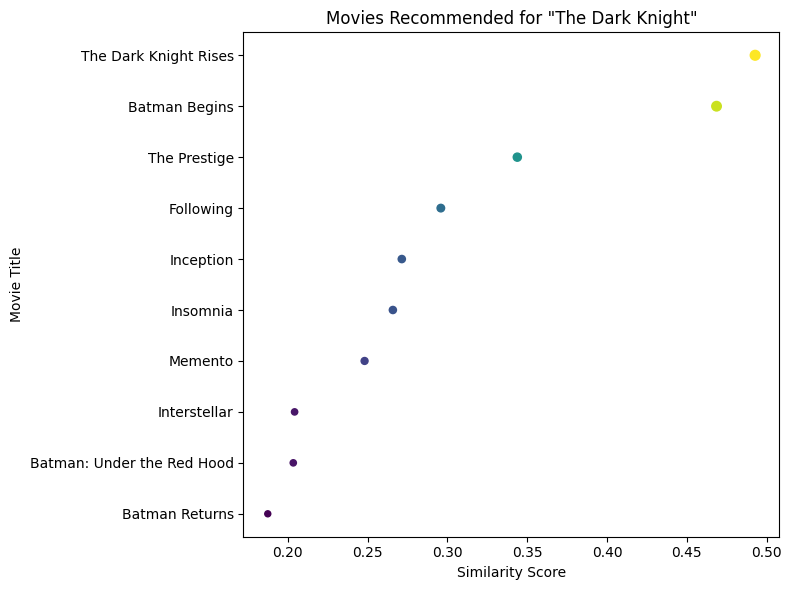

In [ ]:
rec_titles, rec_scores = get_recommendations('The Dark Knight')

# Plot the recommendations with similarity scores
fig, ax = plt.subplots(figsize=(8, 6))
marker_size = np.array(rec_scores) * 100  # Scale the scores for marker size

ax.scatter(rec_scores, np.arange(len(rec_titles)), s=marker_size, c=rec_scores, cmap='viridis')
ax.set_yticks(np.arange(len(rec_titles)))
ax.set_yticklabels(rec_titles, fontsize=10)
ax.invert_yaxis()
ax.set_xlabel('Similarity Score')
ax.set_ylabel('Movie Title')
ax.set_title('Movies Recommended for "The Dark Knight"')

plt.tight_layout()
plt.show()



We can of course experiment on this engine by trying out different weights for our features (directors, actors, genres), limiting the number of keywords that can be used in the soup, weighing genres based on their frequency, only showing movies with the same languages, etc.

Lets also get recommendations for another movie, **The Godfather** 

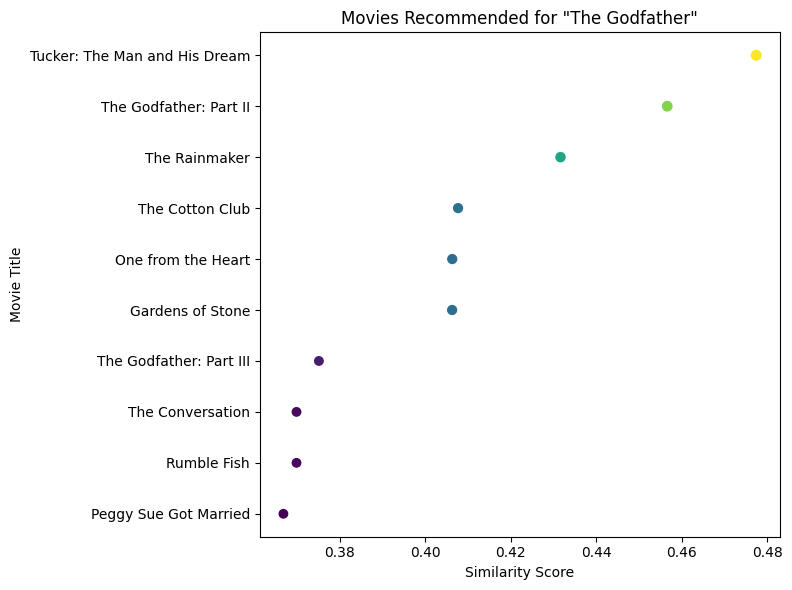

In [ ]:
rec_titles, rec_scores = get_recommendations('The Godfather')

# Plot the recommendations with similarity scores
fig, ax = plt.subplots(figsize=(8, 6))
marker_size = np.array(rec_scores) * 100  # Scale the scores for marker size

ax.scatter(rec_scores, np.arange(len(rec_titles)), s=marker_size, c=rec_scores, cmap='viridis')
ax.set_yticks(np.arange(len(rec_titles)))
ax.set_yticklabels(rec_titles, fontsize=10)
ax.invert_yaxis()
ax.set_xlabel('Similarity Score')
ax.set_ylabel('Movie Title')
ax.set_title('Movies Recommended for "The Godfather"')

plt.tight_layout()
plt.show()

#### Popularity and Ratings

One thing that we notice about our recommendation system is that it recommends movies regardless of ratings and popularity. It is true that **Batman and Robin** has a lot of similar characters as compared to **The Dark Knight** but it was a terrible movie that shouldn't be recommended to anyone.

Therefore, we will add a mechanism to remove bad movies and return movies which are popular and have had a good critical response.

We will take the top 25 movies based on similarity scores and calculate the vote of the 60th percentile movie. Then, using this as the value of $m$, we will calculate the weighted rating of each movie using IMDB's formula like we did in the Simple Recommender section.

In [ ]:
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]

    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)

    qualified = qualified.sort_values('wr', ascending=False).head(10)

    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    ax.barh(qualified['title'], qualified['vote_average'], label='Average Rating')
    ax.barh(qualified['title'], qualified['wr'], label='Weighted Rating')
    ax.invert_yaxis()
    ax.set_xlabel('Rating')
    ax.set_title('Top 10 Recommended Movies')
    ax.legend()

    plt.tight_layout()
    plt.show()

    return qualified

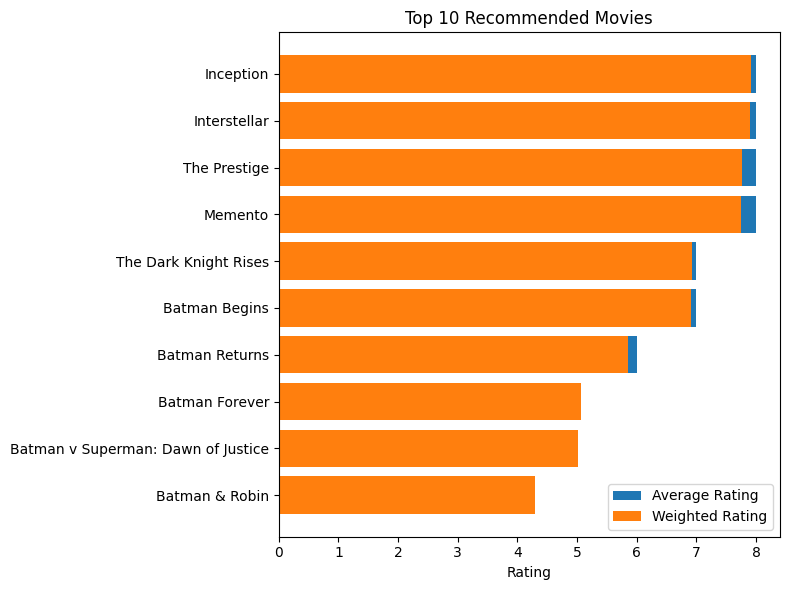

,title,vote_count,vote_average,year,wr
7570,Inception,14075,8,2010,7.917404
8523,Interstellar,11187,8,2014,7.896883
6557,The Prestige,4510,8,2006,7.757704
3364,Memento,4168,8,2000,7.739710
7947,The Dark Knight Rises,9263,7,2012,6.921481


In [ ]:
improved_recommendations('The Dark Knight').head()

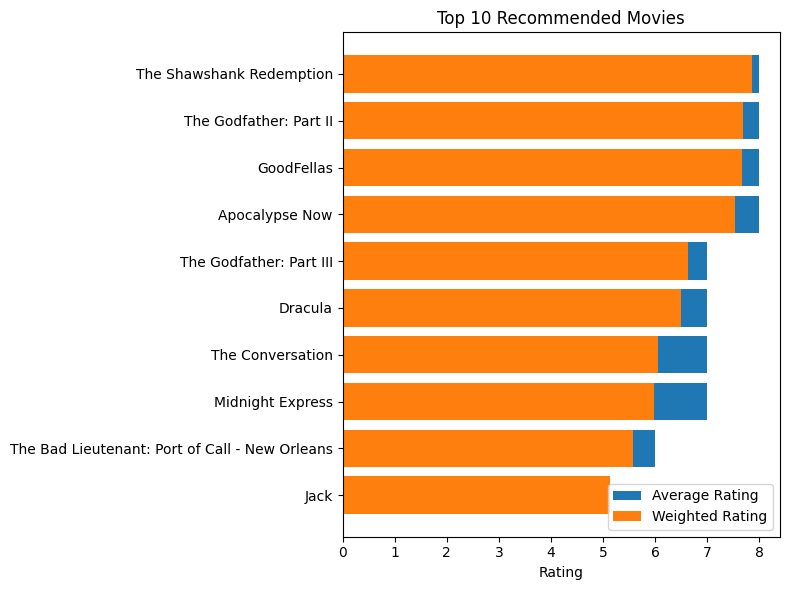

,title,vote_count,vote_average,year,wr
284,The Shawshank Redemption,8358,8,1994,7.863714
977,The Godfather: Part II,3418,8,1974,7.689070
969,GoodFellas,3211,8,1990,7.671426
964,Apocalypse Now,2112,8,1979,7.529762
1585,The Godfather: Part III,1589,7,1990,6.624069


In [ ]:
improved_recommendations('The Godfather').head()

## Collaborative Filtering

Our content based engine suffers from some severe limitations. It is only capable of suggesting movies which are *close* to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who s/he is.

Therefore, in this section, we will use a technique called **Collaborative Filtering** to make recommendations to Movie Watchers. Collaborative Filtering is based on the idea that users similar to a me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.

We will not be implementing Collaborative Filtering from scratch. Instead, We will use the **Surprise** library that used extremely powerful algorithms like **Singular Value Decomposition (SVD)** to minimise RMSE (Root Mean Square Error) and give great recommendations.

In [ ]:
reader = Reader()

In [ ]:
ratings = pd.read_csv('/content/drive/MyDrive/Data/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [ ]:
ratings.duplicated().sum()

0

<h1>Clustering Analysis on Ratings Data<h1>

<h5>We will analyze the ratings_small.csv dataset which contains information about movie ratings. We will use K-means clustering to group the ratings based on their values. We will then check if the sample is good or not based on the cluster labels. Finally, we will use the elbow curve to determine the optimal number of clusters for the data. This analysis will help us understand the patterns and trends in the ratings data and make better decisions about the data.<h5>

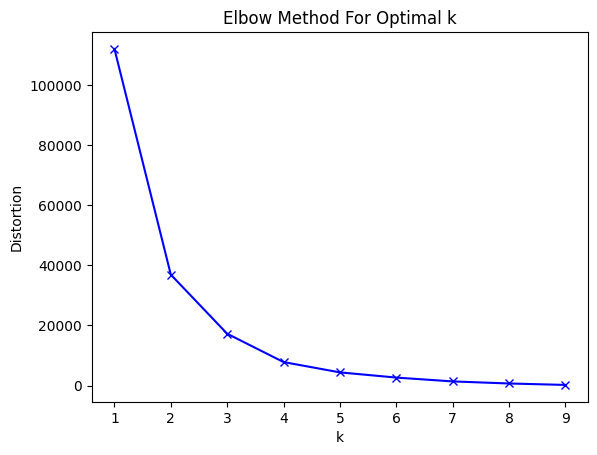

In [ ]:
from sklearn.cluster import KMeans
# Extract the rating column
X = ratings['rating'].values.reshape(-1, 1)

# Perform K-means clustering with k=2 to divide the ratings into two clusters
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

# Add a new column to the ratings dataframe with the cluster labels
ratings['cluster'] = kmeans.labels_

# Check if the sample is good or not based on the cluster labels
good_sample = False
if len(ratings[ratings['cluster'] == 0]) > len(ratings[ratings['cluster'] == 1]):
    good_sample = True

# Plot the elbow curve to choose the optimal number of clusters
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    distortions.append(kmeanModel.inertia_)

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
kf = KFold(n_splits=5)
kf.split(data)

In [ ]:
svd = SVD()
results=cross_validate(svd, data, measures=['RMSE', 'MAE'])

In [ ]:
print("Average RMSE:", round(np.mean(results['test_rmse']), 4))#Root Mean Squared Error
print("Average MAE:", round(np.mean(results['test_mae']), 4))#Mean Absolute Error

Average RMSE: 0.8961
Average MAE: 0.6892


In [ ]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [ ]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [ ]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.625261596035984, details={'was_impossible': False})

For movie with ID 302, we get an estimated prediction of **2.836**. One startling feature of this recommender system is that it doesn't care what the movie is (or what it contains). It works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

## Hybrid Recommender

![](https://www.toonpool.com/user/250/files/hybrid_20095.jpg)

In this section, We will try to build a simple hybrid recommender that brings together techniques we have implemented in the content based and collaborative filter based engines. This is how it will work:

* **Input:** User ID and the Title of a Movie
* **Output:** Similar movies sorted on the basis of expected ratings by that particular user.

In [ ]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [ ]:
id_map = pd.read_csv('/content/drive/MyDrive/Data/links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')
#id_map = id_map.set_index('tmdbId')

In [ ]:
indices_map = id_map.set_index('id')

In [ ]:
def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [ ]:
hybrid(1, "Avatar")

,title,vote_count,vote_average,year,id,est
522,Terminator 2: Judgment Day,4274.0,7.7,1991,280,3.244430
994,The Terminator,4208.0,7.4,1984,218,3.084376
8311,Star Trek Into Darkness,4479.0,7.4,2013,54138,2.960022
957,Aliens,3282.0,7.7,1986,679,2.856109
8568,X-Men: Days of Future Past,6155.0,7.5,2014,127585,2.845665
1604,Darby O'Gill and the Little People,35.0,6.7,1959,18887,2.775588
905,The Abyss,822.0,7.1,1989,2756,2.742372
1997,Fantastic Planet,140.0,7.6,1973,16306,2.727298
1651,Return from Witch Mountain,38.0,5.6,1978,14822,2.677806
7199,Dragonball Evolution,475.0,2.9,2009,14164,2.671663


In [ ]:
hybrid(500, "Avatar")

,title,vote_count,vote_average,year,id,est
994,The Terminator,4208.0,7.4,1984,218,3.396233
8568,X-Men: Days of Future Past,6155.0,7.5,2014,127585,3.343887
957,Aliens,3282.0,7.7,1986,679,3.328795
4308,Piranha Part Two: The Spawning,41.0,3.9,1981,31646,3.155083
522,Terminator 2: Judgment Day,4274.0,7.7,1991,280,3.153175
1997,Fantastic Planet,140.0,7.6,1973,16306,3.119025
3990,Hawk the Slayer,13.0,4.5,1980,25628,3.067425
905,The Abyss,822.0,7.1,1989,2756,3.018374
8311,Star Trek Into Darkness,4479.0,7.4,2013,54138,2.961335
344,True Lies,1138.0,6.8,1994,36955,2.955451


We see that for our hybrid recommender, we get different recommendations for different users although the movie is the same. Hence, our recommendations are more personalized and tailored towards particular users.

## Conclusion

In this notebook, We have built 4 different recommendation engines based on different ideas and algorithms. They are as follows:

1. **Simple Recommender:** This system used overall TMDB Vote Count and Vote Averages to build Top Movies Charts, in general and for a specific genre. The IMDB Weighted Rating System was used to calculate ratings on which the sorting was finally performed.
2. **Content Based Recommender:** We built two content based engines; one that took movie overview and taglines as input and the other which took metadata such as cast, crew, genre and keywords to come up with predictions. We also deviced a simple filter to give greater preference to movies with more votes and higher ratings.
3. **Collaborative Filtering:** We used the powerful Surprise Library to build a collaborative filter based on single value decomposition. The RMSE obtained was less than 1 and the engine gave estimated ratings for a given user and movie.
4. **Hybrid Engine:** We brought together ideas from content and collaborative filterting to build an engine that gave movie suggestions to a particular user based on the estimated ratings that it had internally calculated for that user.
